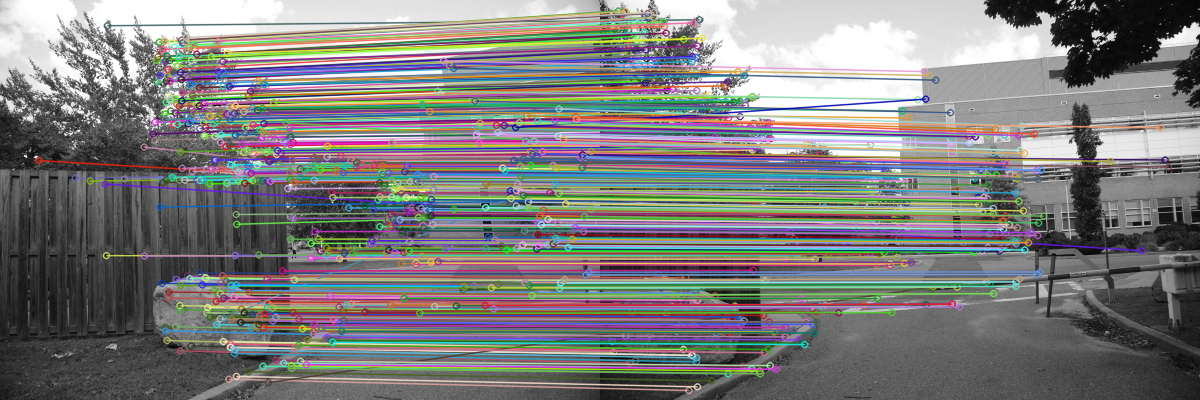

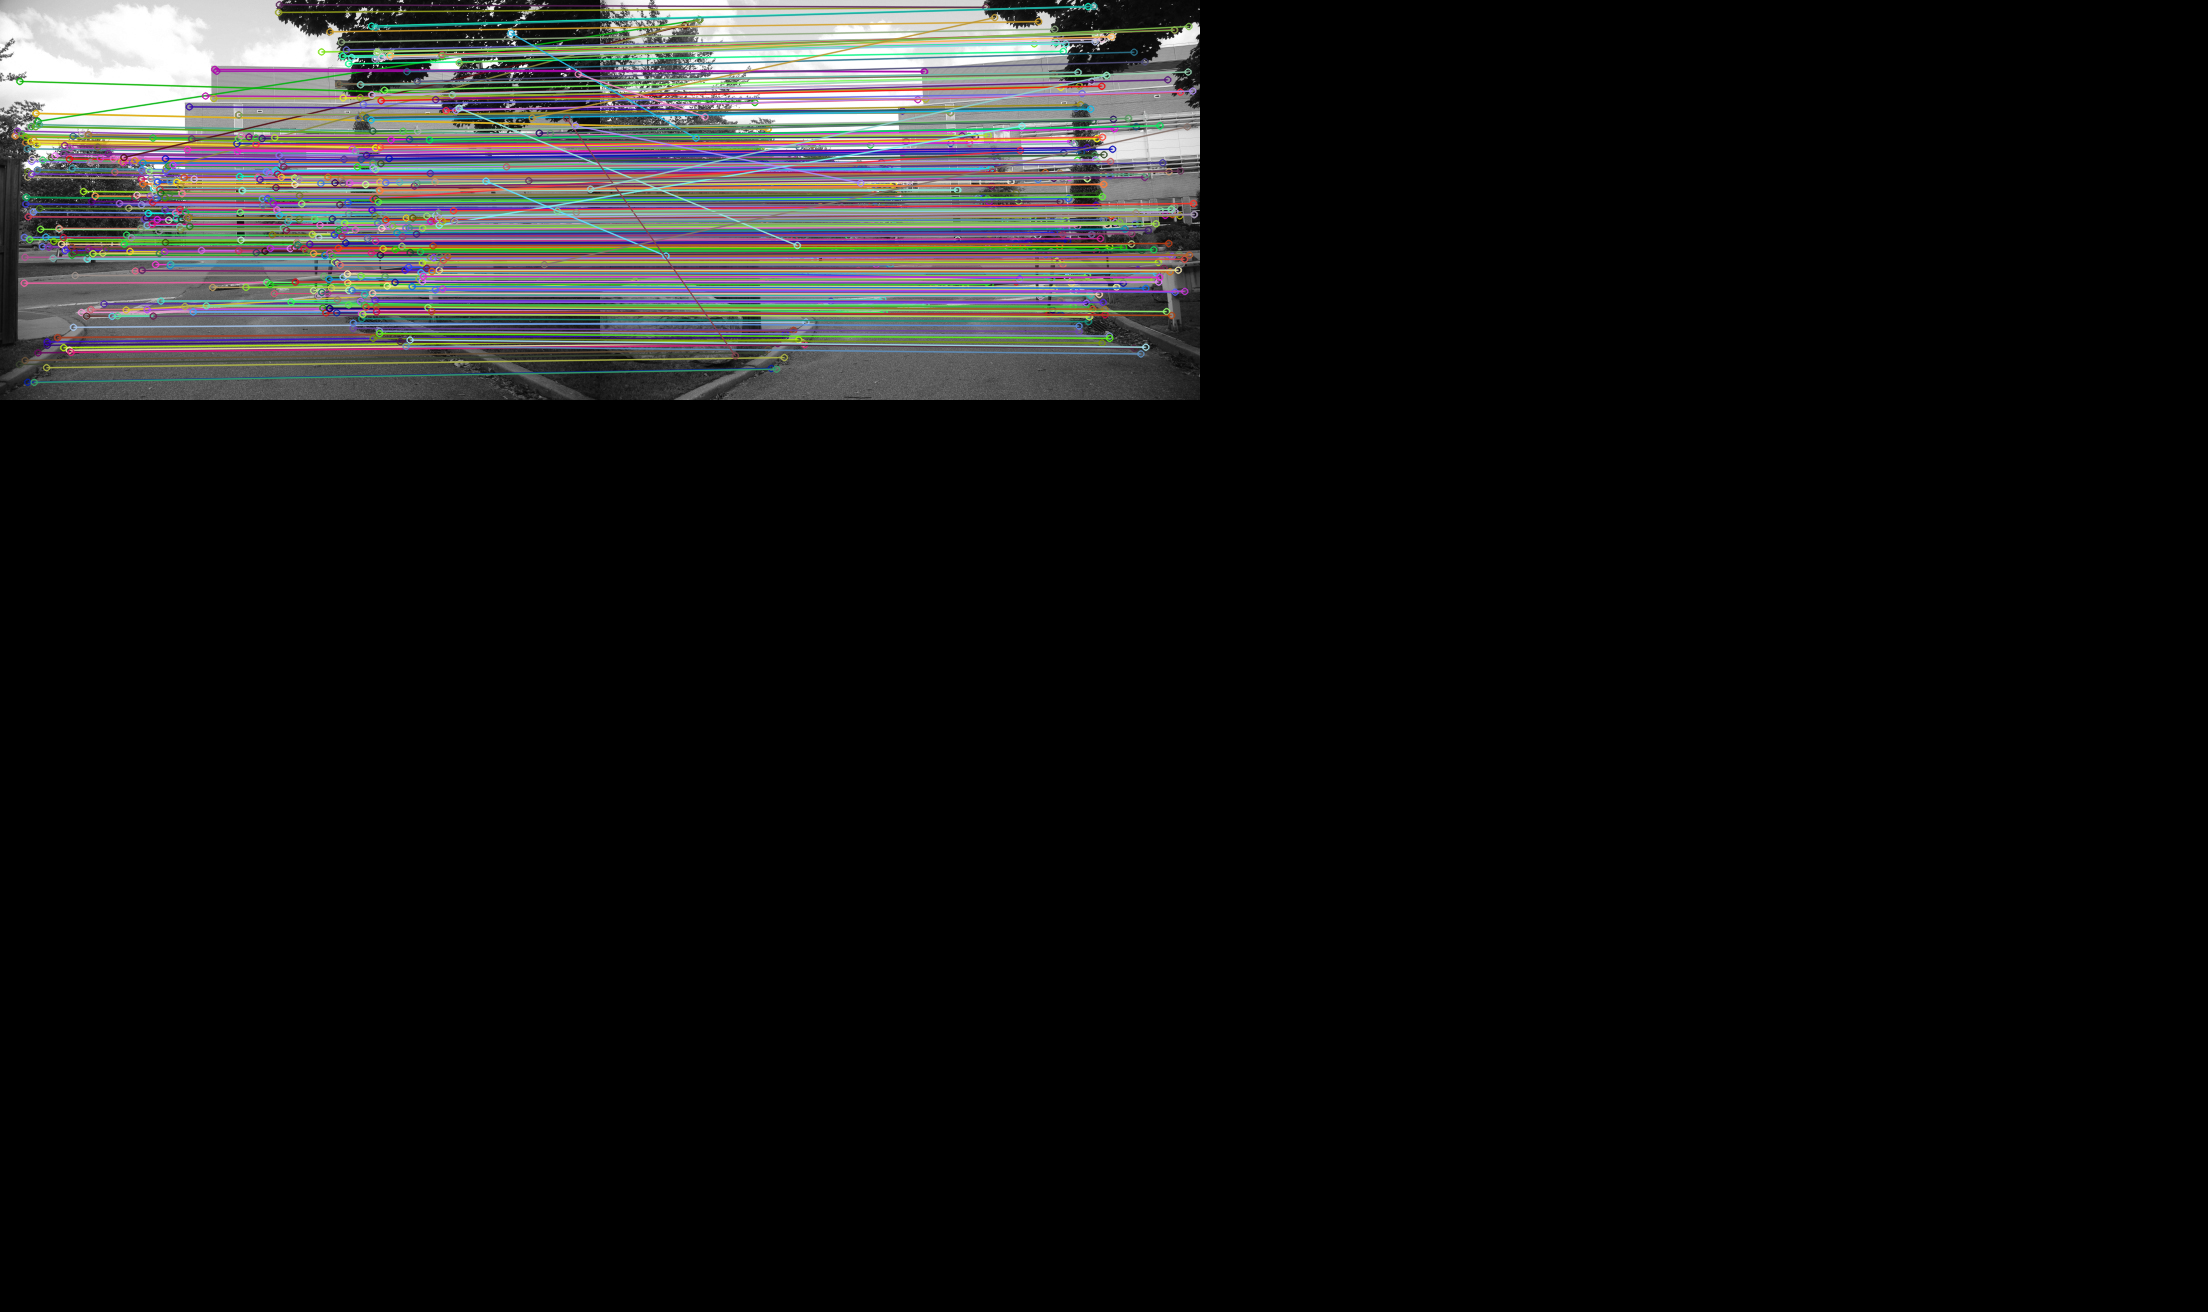

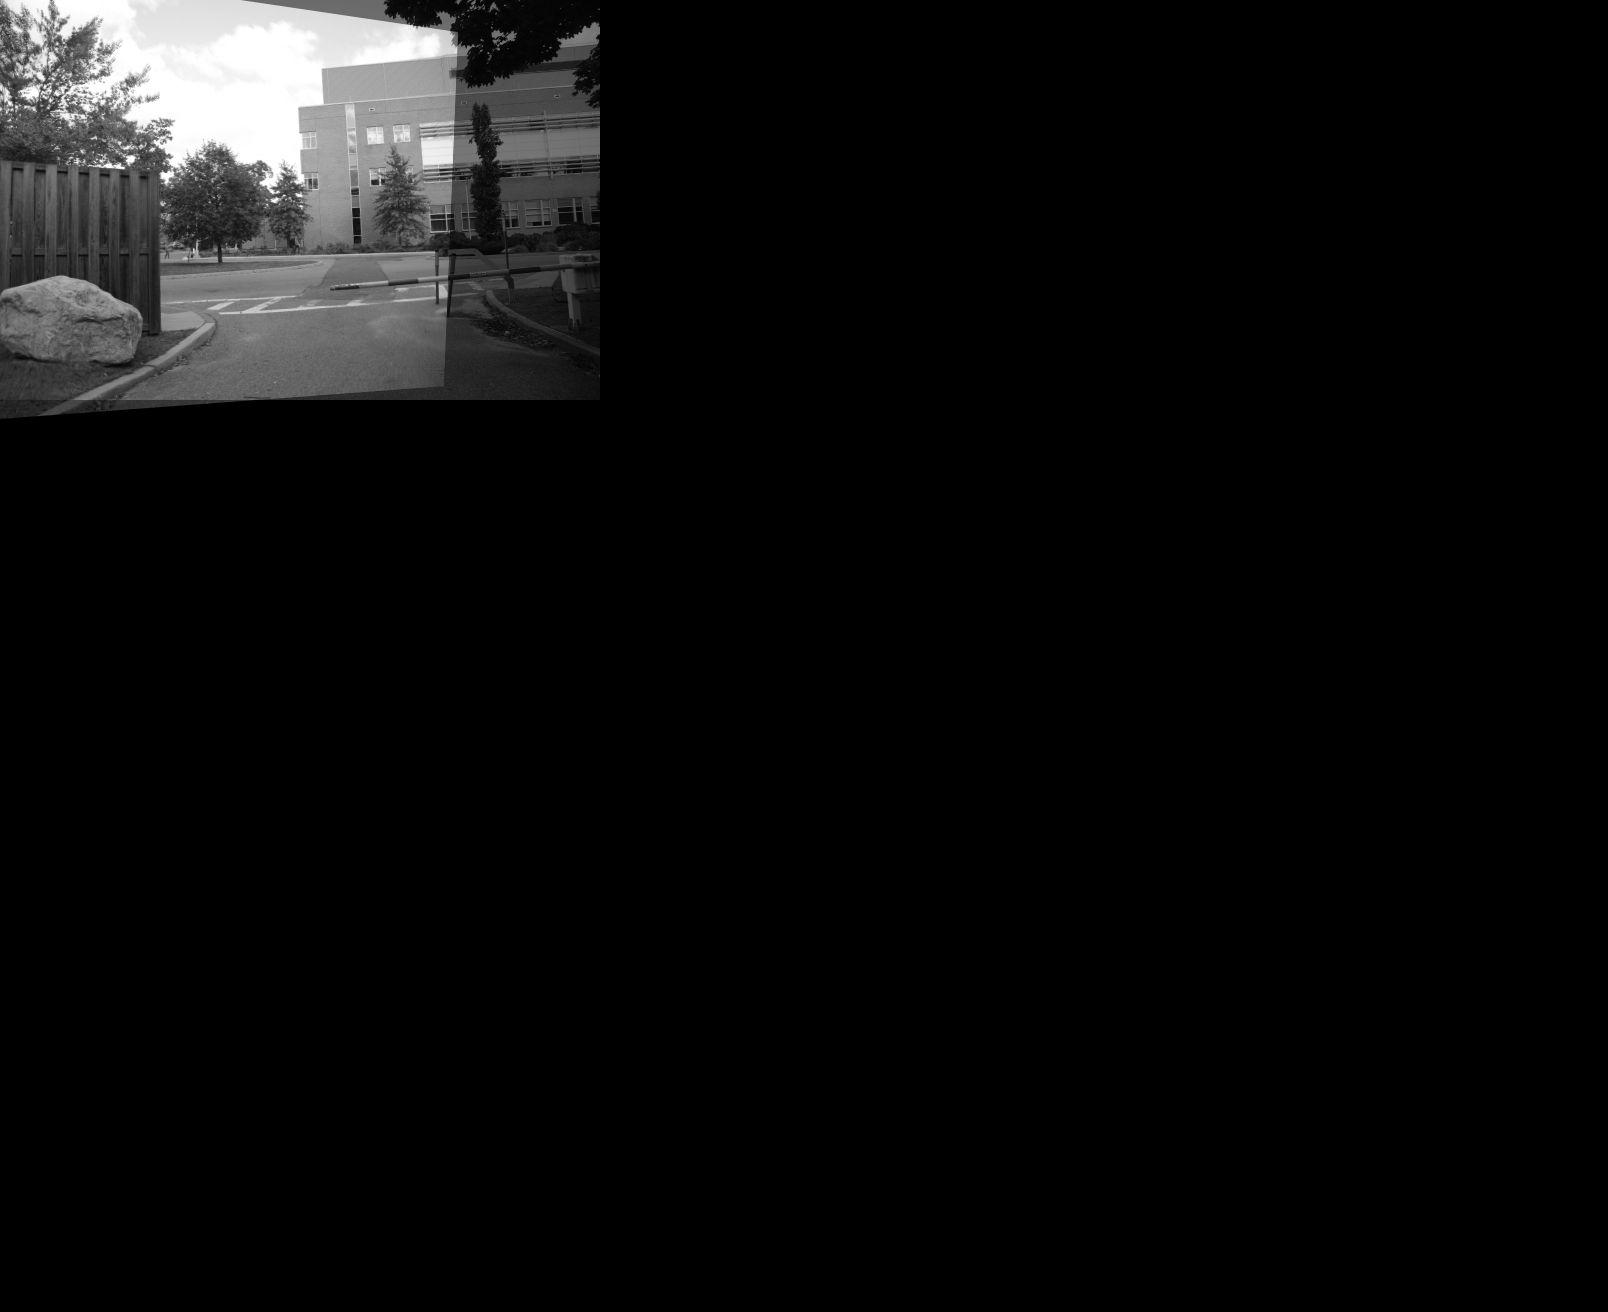

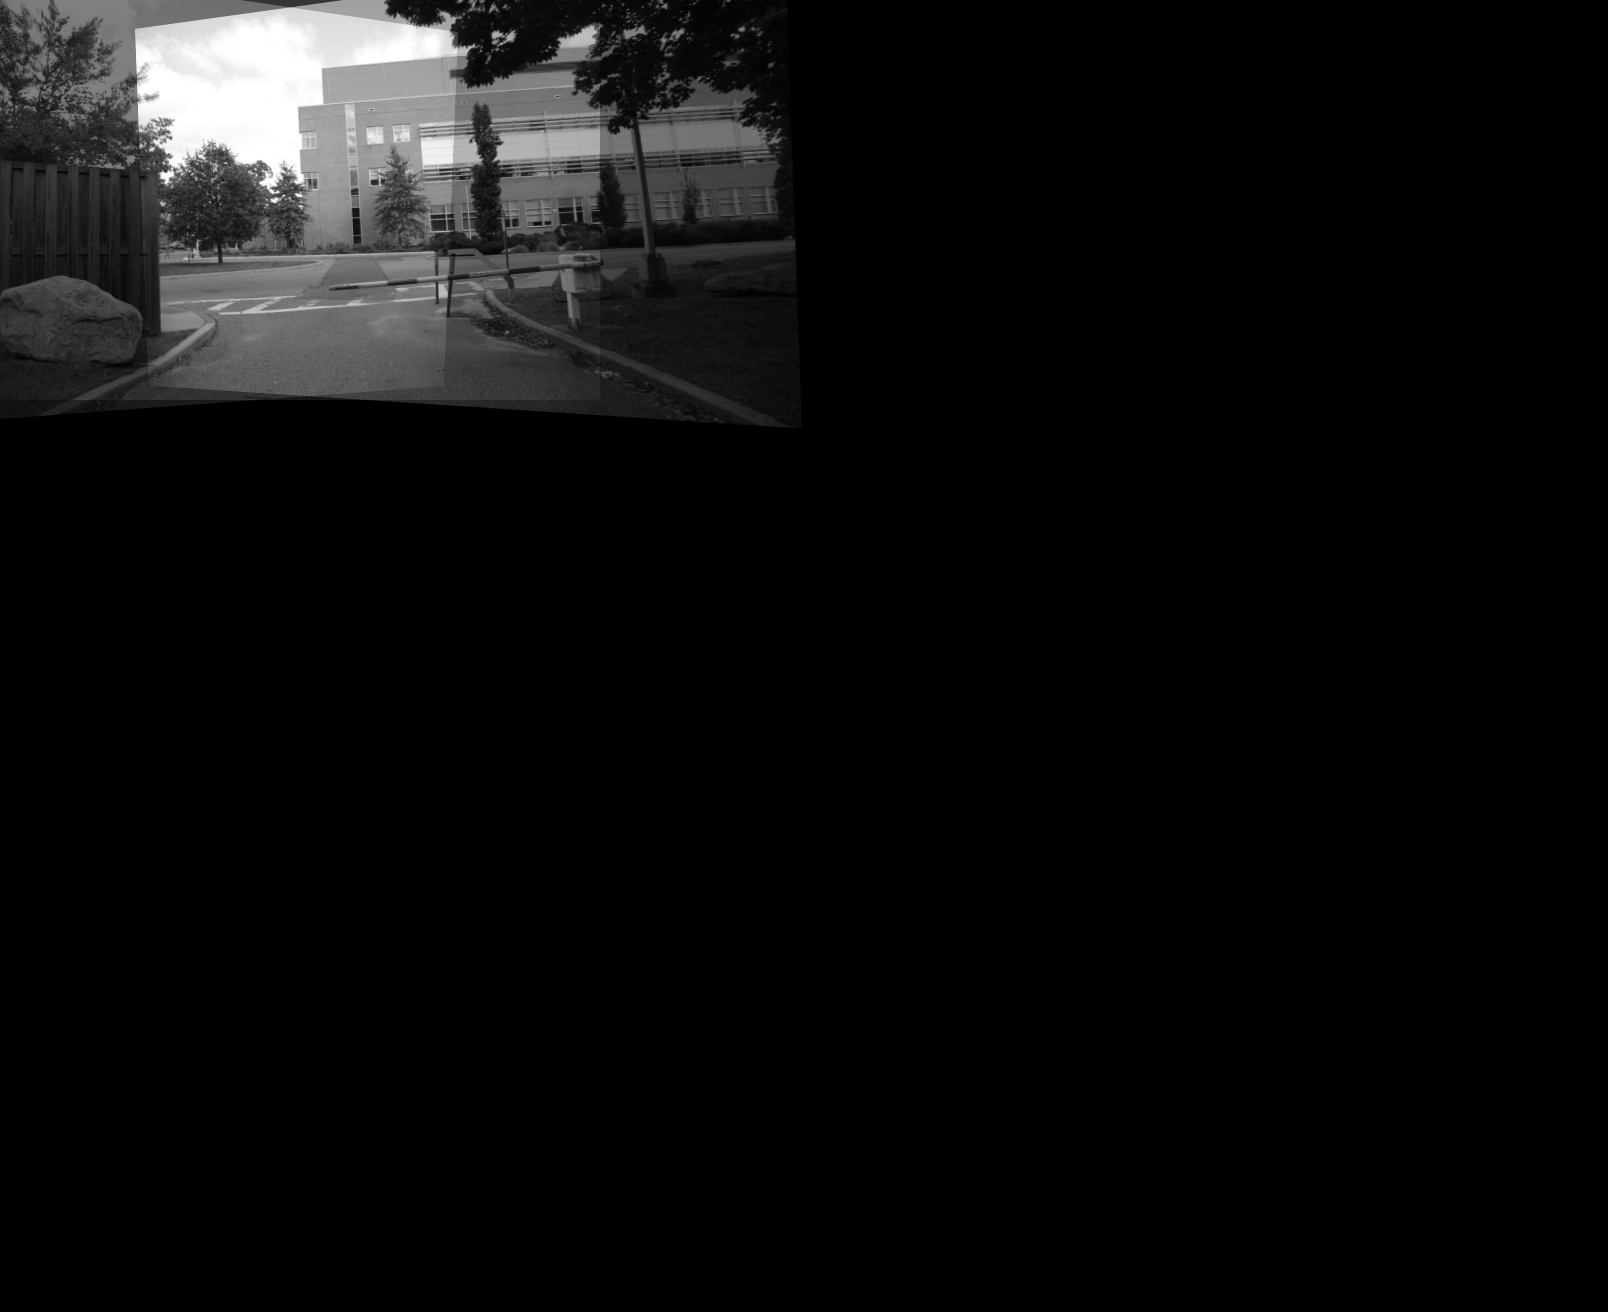

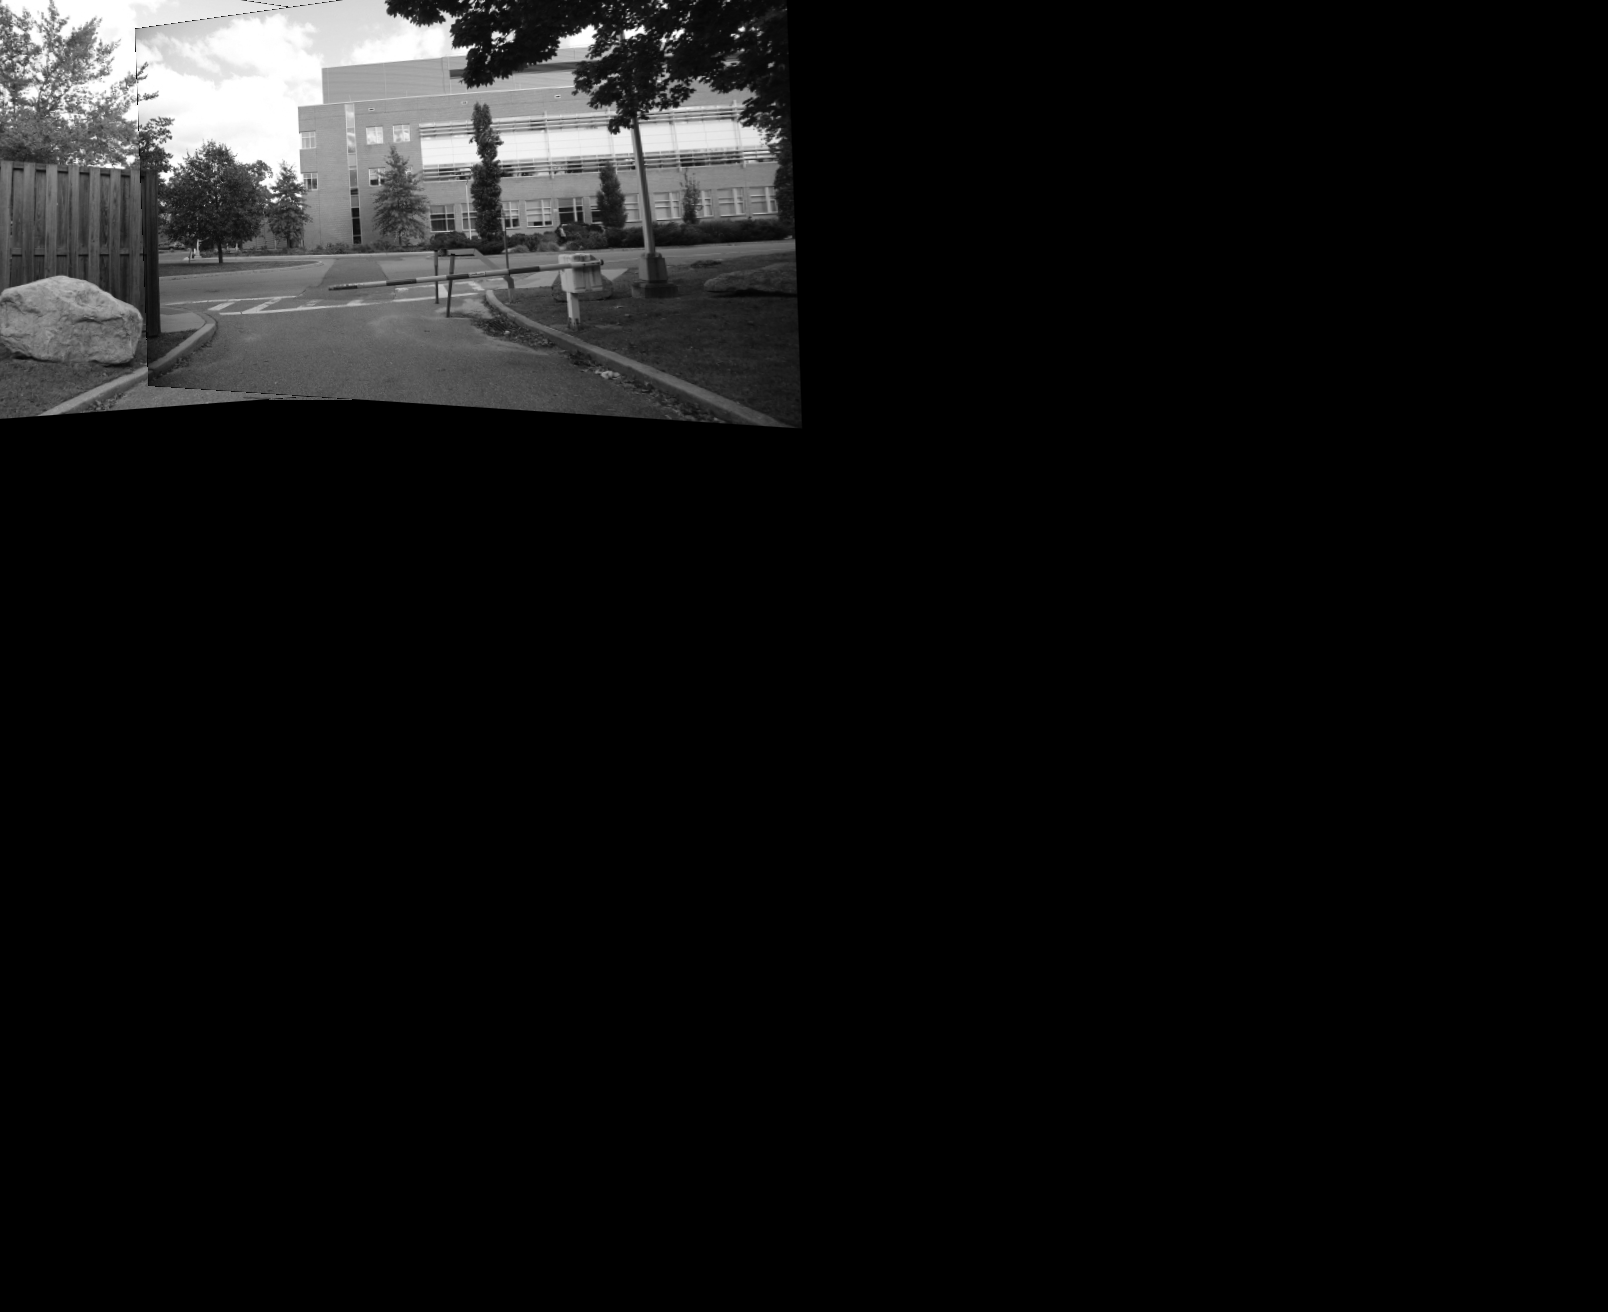

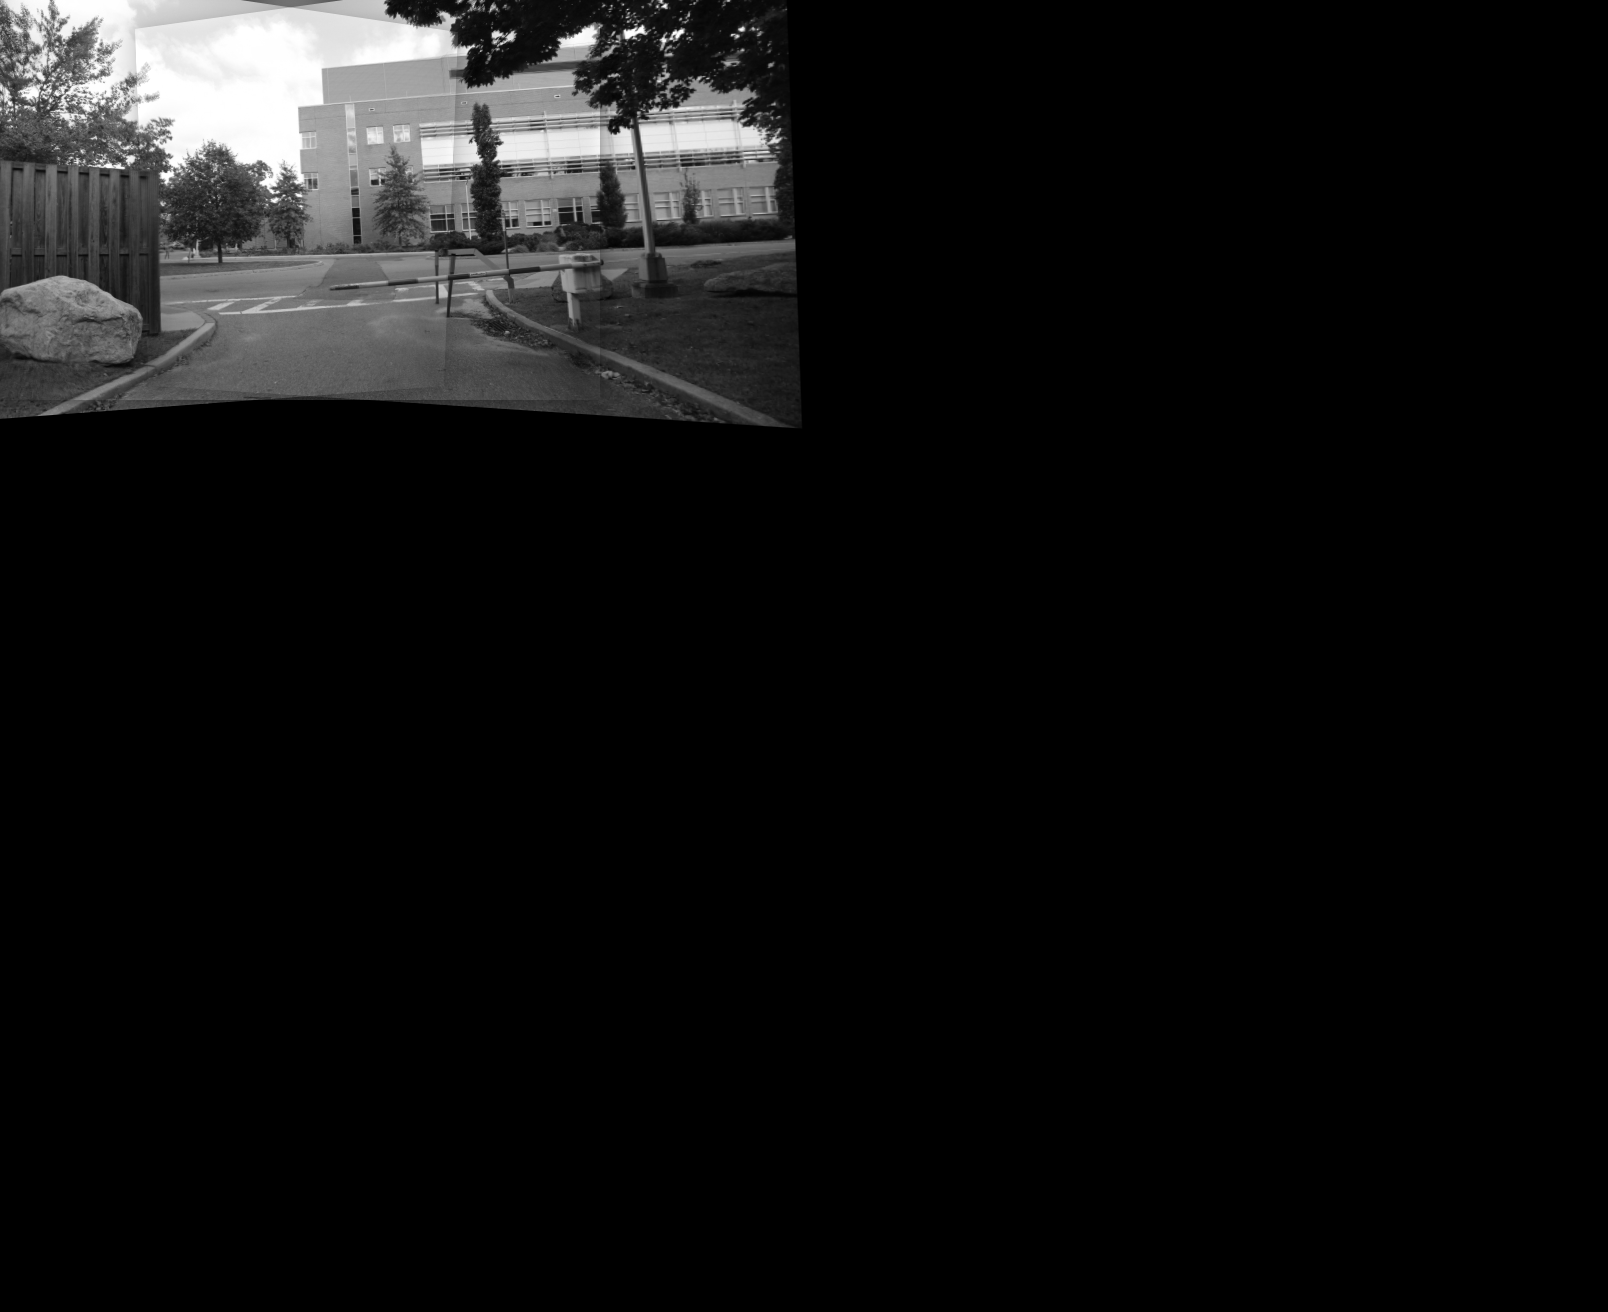

In [ ]:
!pip install opencv-python opencv-contrib-python --quiet
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Step 1: Feature Matching and Homography Calculation
def sift_match_and_homography(img1, img2):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])
    H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)
    match_vis = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=2)
    return H, match_vis

# Step 2: Simple Blending (for visualization)
def add_weighted_blend(img1, img2):
    return cv2.addWeighted(img1, 0.5, img2, 0.5, 0)

# Step 3: Mask-based Blending
def mask_blend(base, warped):
    gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    _, mask_bin = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    inv_mask = cv2.bitwise_not(mask_bin)
    base_bg = cv2.bitwise_and(base, base, mask=inv_mask)
    warped_fg = cv2.bitwise_and(warped, warped, mask=mask_bin)
    return cv2.add(base_bg, warped_fg)

# Step 4: Multi-band Blending Functions
def build_gaussian_pyramid(img, levels=5):
    G = [img.astype(np.float32)]
    for _ in range(levels - 1):
        img = cv2.pyrDown(G[-1])
        G.append(img)
    return G

def build_laplacian_pyramid(G):
    L = [G[-1]]
    for i in range(len(G) - 1, 0, -1):
        GE = cv2.pyrUp(G[i], dstsize=(G[i - 1].shape[1], G[i - 1].shape[0]))
        L.append(G[i - 1] - GE)
    return L[::-1]

def multi_laplacian_blend(imgs, masks, levels=5):
    GP, MP, LP = [], [], []
    n = len(imgs)
    for i in range(n):
        GP.append(build_gaussian_pyramid(imgs[i], levels))
        MP.append(build_gaussian_pyramid(masks[i], levels))
        LP.append(build_laplacian_pyramid(GP[i]))

    BL = []
    for lev in range(len(GP[0])):
        ws = np.zeros_like(MP[0][lev])
        for j in range(n):
            ws += MP[j][lev]
        ws[ws == 0] = 1
        out = np.zeros_like(LP[0][lev])
        for j in range(n):
            w = MP[j][lev] / ws
            if len(w.shape) == 2:
                w = w[..., None]
            out += LP[j][lev] * w
        BL.append(out)

    result = BL[-1]
    for i in range(len(BL) - 2, -1, -1):
        up = cv2.pyrUp(result, dstsize=(BL[i].shape[1], BL[i].shape[0]))
        result = up + BL[i]

    return np.clip(result, 0, 255).astype(np.uint8)

# Load images
left = cv2.imread('Left.jpg')
middle = cv2.imread('Middle.jpg')
right = cv2.imread('Right.jpg')

# Prepare canvas
out_h, out_w = 1312, 1608
padded_middle = cv2.copyMakeBorder(middle, 0, out_h - middle.shape[0], 0, out_w - middle.shape[1], cv2.BORDER_CONSTANT, value=0)

# Step 1: Feature Matching and Homography Estimation
H_lm, vis_lm = sift_match_and_homography(left, middle)
cv2_imshow(vis_lm)
warp_left = cv2.warpPerspective(left, H_lm, (padded_middle.shape[1], padded_middle.shape[0]))

H_rm, vis_rm = sift_match_and_homography(right, padded_middle)
cv2_imshow(vis_rm)
warp_right = cv2.warpPerspective(right, H_rm, (padded_middle.shape[1], padded_middle.shape[0]))

# Step 2: Simple Blending for Visualization
step1_add = add_weighted_blend(padded_middle, warp_left)
cv2_imshow(step1_add)
final_add = add_weighted_blend(step1_add, warp_right)
cv2_imshow(final_add)

# Step 3: Mask-based Blending
step1_mask = mask_blend(padded_middle.copy(), warp_left)
final_mask = mask_blend(step1_mask, warp_right)
cv2_imshow(final_mask)

# Step 4: Laplacian Pyramid Blending
# Convert images to grayscale to create masks
ml = cv2.cvtColor(warp_left, cv2.COLOR_BGR2GRAY)
_, ml = cv2.threshold(ml, 1, 255, cv2.THRESH_BINARY)
ml = cv2.GaussianBlur(ml, (35, 35), 0).astype(np.float32)

mm = cv2.cvtColor(padded_middle, cv2.COLOR_BGR2GRAY)
_, mm = cv2.threshold(mm, 1, 255, cv2.THRESH_BINARY)
mm = cv2.GaussianBlur(mm, (35, 35), 0).astype(np.float32)

mr = cv2.cvtColor(warp_right, cv2.COLOR_BGR2GRAY)
_, mr = cv2.threshold(mr, 1, 255, cv2.THRESH_BINARY)
mr = cv2.GaussianBlur(mr, (35, 35), 0).astype(np.float32)

# Blend the images using multi-band blending
imgs = [warp_left, padded_middle, warp_right]
masks = [ml, mm, mr]
result = multi_laplacian_blend(imgs, masks, levels=5)

cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()
